[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Fernigithub/series_temporales_101/blob/main/notebooks/smoothing.ipynb)

# Smoothing

<img src="media/mgeo.png" style="width: 40%; display: block; margin: auto;">

- En esta parte exploraremos otro concepto importante llamado **suavizado**.
- En particular, cubriremos:
    1. Una introducción al suavizado y por qué es necesario.
    2. Técnicas comunes de suavizado.
    3. Cómo suavizar datos de series temporales con Python y generar pronósticos.

In [1]:
import sys

# Install dependencies if the notebook is running in Colab
if 'google.colab' in sys.modules:
    !pip install -U -qq tsa-course

In [1]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from io import BytesIO
from tsa_course.lecture2 import run_sequence_plot
np.random.seed(0) # reproducibility

---

## Smoothing

- Un proceso de recolección de datos a menudo se ve afectado por ruido.
- Si es demasiado fuerte, el ruido puede ocultar patrones útiles en los datos.
- El suavizado es una técnica bien conocida y frecuentemente utilizada para recuperar esos patrones mediante *el filtrado de ruido*.
- También puede ser utilizado para *hacer pronósticos* proyectando los patrones recuperados hacia el futuro.

- Exploraremos dos técnicas importantes para realizar suavizado:
    1. Suavizado simple.
    2. Suavizado exponencial.

- Comenzamos generando algunos datos estacionarios.
- Discutimos la importancia de inspeccionar visualmente la serie temporal con un gráfico de secuencia de ejecución.
- Por lo tanto, también definiremos la función `run_sequence_plot` para visualizar nuestros datos.

In [2]:
# Generate stationary data
time = np.arange(100)
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))

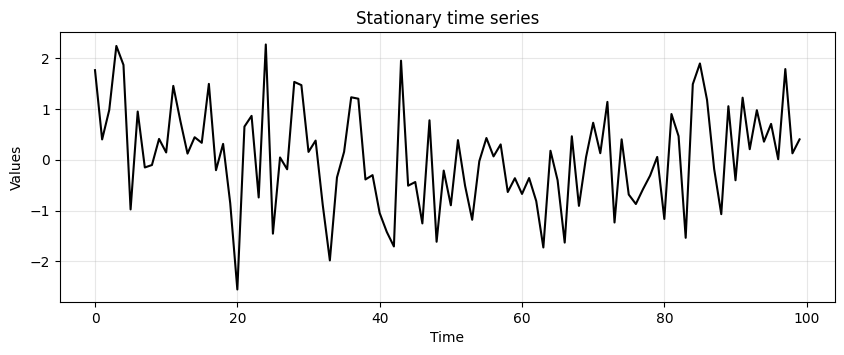

In [3]:
run_sequence_plot(time, stationary, title="Stationary time series");


---

## Simple smoothing

- Existen muchas técnicas para suavizar datos.
- Las más simples son:
    1. Promedio simple
    2. Promedio móvil
    3. Promedio móvil ponderado

### Promedio simple

- El promedio simple es la técnica más básica.
- Considera los datos estacionarios mencionados anteriormente.
- La forma más conservadora de representarlos es a través de su **media**.
- La media puede ser utilizada para predecir los valores futuros de la serie temporal.
- Este tipo de representación se llama *promedio simple*.

In [5]:
# media de la serie estacionaria
stationary_time_series_avg = np.mean(stationary)

# crea un array compuesto por el valor medio y de igual longitud que el array de tiempo
sts_avg = np.full(shape=len(time), fill_value=stationary_time_series_avg, dtype='float')

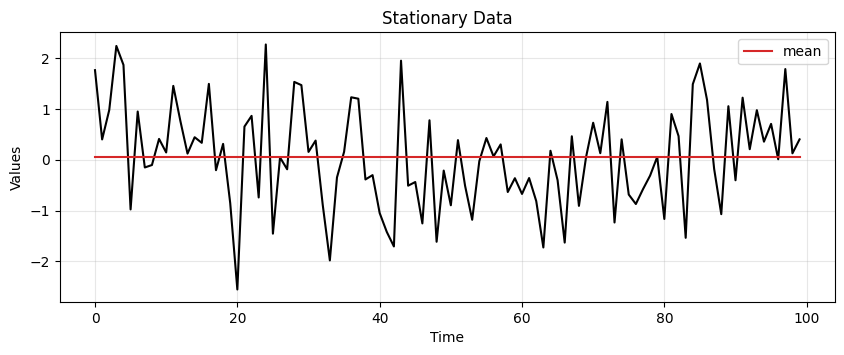

In [6]:
ax = run_sequence_plot(time, stationary, title="Stationary Data")
ax.plot(time, sts_avg, 'tab:red', label="mean")
plt.legend();

### Error cuadrático medio (MSE)

- La aproximación con la media parece razonable en este caso.
- En general, queremos medir cuánto se desvía nuestra estimación de la realidad.
- Una forma común de hacerlo es calculando el *Error Cuadrático Medio* (MSE)

$$MSE = \frac{1}{T}\sum_{t=1}^{T} (X(t) - \hat{X}(t))^2$$

- donde $X(t)$ y $\hat{X}(t)$ son los valores verdaderos y estimados en el tiempo $t$, respectivamente.

**Ejemplo**

- Consideremos el siguiente ejemplo.
- Supongamos que tenemos una serie temporal de valores observados $X = [0, 1, 3, 2]$.
- Las predicciones dadas por nuestro modelo son $\hat{X} =  [1, 1, 2, 4]$. 
- Calculamos el MSE como: 

$$(0-1)^{2} + (1-1)^{2} + (3-2)^{2} + (2-4)^{2} = 6$$

- Supongamos que tuviéramos otro modelo que nos diera la estimación $\hat{X} =  [0, 0, 1, 0]$.
- El MSE en este caso es: 

$$0^{2} + 1^{2} + 2^{2} + 2^{2} = 9$$

- El MSE permite comparar diferentes estimaciones para ver cuál es la mejor.
- En este caso, el primer modelo nos da una mejor estimación que el segundo.
- Esta idea de medir cómo se desempeña un modelo es importante en el aprendizaje automático y la utilizaremos a menudo en este curso.
- Creemos una función para calcular el MSE que utilizaremos a medida que avanzamos.

In [7]:
def mse(observations, estimates):
    """
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    """
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [8]:
zeros = mse(np.array([0, 1, 3, 2]), np.array([1, 1, 2, 4]))
print(zeros)

6


In [9]:
ones = mse(np.array([0, 1, 3, 2]), np.array([0, 0, 1, 0]))
print(ones)

9


- A continuación, añadimos una *tendencia* a nuestra serie temporal estacionaria.

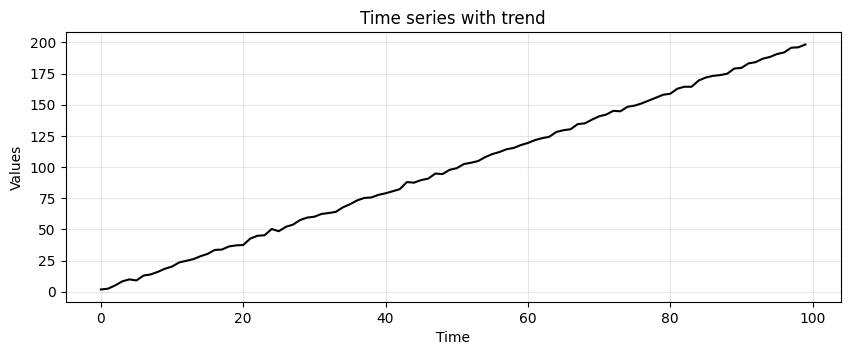

In [10]:
trend = (time * 2.0) + stationary
run_sequence_plot(time, trend, title="Time series with trend");

- Supongamos que usamos nuevamente el promedio simple para representar la serie temporal.

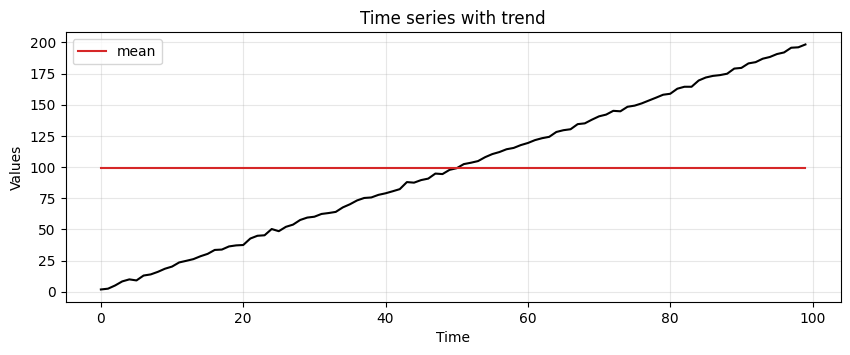

In [11]:
# find mean of series
trend_time_series_avg = np.mean(trend)

# create array of mean value equal to length of time array
avg_trend = np.full(shape=len(time), fill_value=trend_time_series_avg, dtype='float')

run_sequence_plot(time, trend, title="Time series with trend")
plt.plot(time, avg_trend, 'tab:red', label="mean")
plt.legend();

- Claramente, el promedio simple no funciona bien en este caso.
- Debemos encontrar otras formas de capturar el patrón subyacente en los datos.
- Comenzamos con algo llamado *promedio móvil*.

### Promedio Móvil (MA)

- El promedio móvil tiene una mayor sensibilidad que el promedio simple a los cambios locales en los datos.
- La forma más fácil de entender el promedio móvil es mediante un ejemplo.
- Digamos que tenemos los siguientes valores:

<img src="media/values.png" style="width: 30%; display: block; margin: auto;">

- El primer paso es seleccionar un tamaño de ventana.
- Elegiremos arbitrariamente un tamaño de 3.
- Luego, comenzamos a calcular el promedio de los primeros tres valores y almacenamos el resultado.
- Después, deslizamos la ventana en uno y calculamos el promedio de los siguientes tres valores.
- Repetimos este proceso hasta que alcancemos el último valor observado.

<img src="media/EqWMA.gif" style="width: 40%; display: block; margin: auto;">

- Ahora, definamos una función para realizar el suavizado con el MA.
- Luego, comparamos el MSE obtenido al aplicar el promedio simple y el promedio móvil en los datos con tendencia.

In [12]:
def moving_average(observations, window=3, forecast=False):
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    if forecast:
        return np.insert(cumulative_sum[window - 1:] / window, 0, np.zeros(window-1))
    else:
        return cumulative_sum[window - 1:] / window

In [13]:
MA_trend = moving_average(trend, window=3)

print(f"MSE:\n--------\nsimple average: {mse(trend, avg_trend):.2f}\nmoving_average: {mse(trend[2:], MA_trend):.2f}")

MSE:
--------
simple average: 332400.58
moving_average: 448.32


- Claramente, el MA logra captar mucho mejor los datos de tendencia.
- También podemos trazar el resultado contra la serie temporal real.

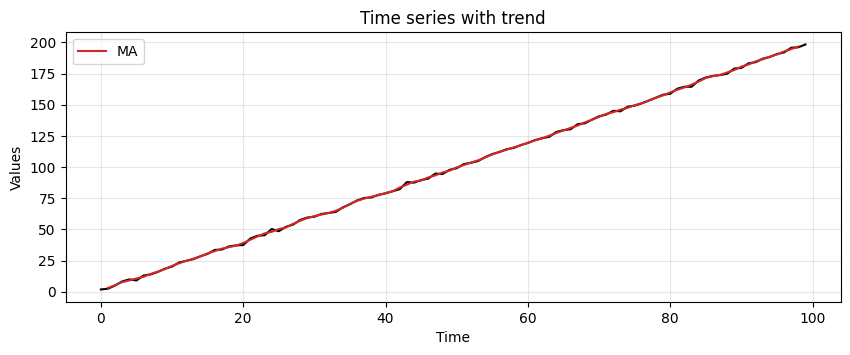

In [14]:
run_sequence_plot(time, trend, title="Time series with trend")
plt.plot(time[1:-1], MA_trend, 'tab:red', label="MA")
plt.legend();

- Tenga en cuenta que la salida del MA es más corta que los datos originales.
- La razón es que la ventana móvil no está centrada en los primeros y últimos elementos de la serie temporal.
- Dado un tamaño de ventana de $P$, el MA será $P-1$ pasos más corto que la serie temporal original.

In [15]:
x = np.arange(20)
print(len(moving_average(x, window=9)))

12


- Ahora, probamos el MA en una serie temporal periódica, que podría representar una estacionalidad.

In [16]:
seasonality = 10 + np.sin(time) * 10
MA_seasonality = moving_average(seasonality, window=3)

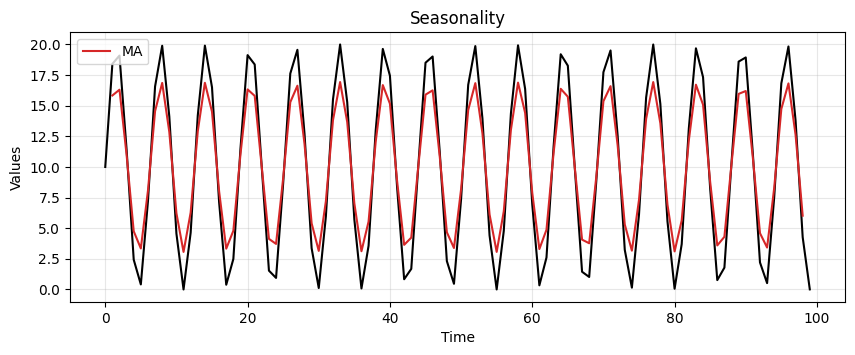

In [17]:
run_sequence_plot(time, seasonality, title="Seasonality")
plt.plot(time[1:-1], MA_seasonality, 'tab:red', label="MA")
plt.legend(loc='upper left');

- No es perfecto, pero claramente capta el patrón periódico.
- Por último, veamos cómo el MA maneja la tendencia, la estacionalidad y un poco de ruido.

In [18]:
trend_seasonality = trend + seasonality + stationary
MA_trend_seasonality = moving_average(trend_seasonality, window=3)

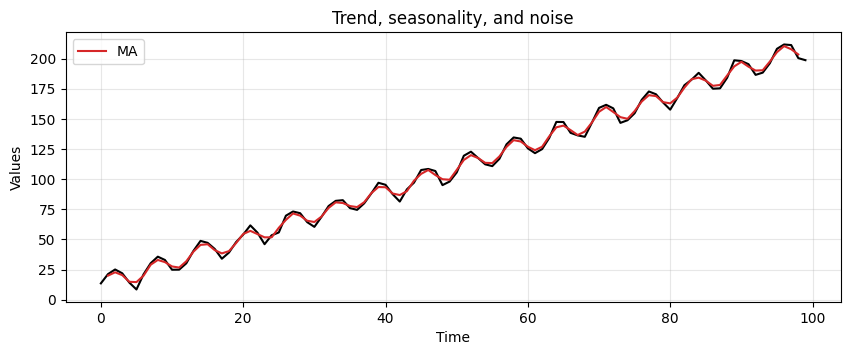

In [19]:
run_sequence_plot(time, trend_seasonality, title="Trend, seasonality, and noise")
plt.plot(time[1:-1], MA_trend_seasonality, 'tab:red', label="MA")
plt.legend(loc='upper left');

- Este método está captando patrones clave en estos conjuntos de datos de juguete.
- Sin embargo, tiene varias limitaciones.

1. El MA asigna la misma importancia a todos los valores en la ventana, independientemente de su orden cronológico.
    - Por esta razón, falla en capturar las tendencias recientes, que a menudo son más relevantes.

2. El MA requiere la selección de un tamaño de ventana específico, el cual puede ser arbitrario y no adecuarse a todos los tipos de datos.
 - una ventana pequeña puede llevar a ruido
 - una ventana demasiado grande podría suavizar demasiado los datos, perdiendo fluctuaciones importantes a corto plazo.

3. El MA no se ajusta a cambios en la tendencia o estacionalidad.
    - Esto puede llevar a predicciones inexactas, especialmente cuando estos componentes son no lineales y dependientes del tiempo.

### Promedio Móvil Ponderado (WMA)

- El WMA da más peso a las observaciones recientes que a las más distantes.
- Esto tiene sentido intuitivo.
    - Piensa en el mercado de valores: se ha observado que el precio de hoy es un buen predictor del precio de mañana.
- Al aplicar pesos desiguales a las observaciones pasadas, podemos controlar cuánto afecta cada una al pronóstico futuro.

- Hay muchas formas de establecer los pesos.
- Por ejemplo, podríamos definirlos con el siguiente sistema de ecuaciones:

$$
\begin{cases}
& w_1 + w_2 + w_3 = 1\\ 
& w_2 = (w_1)^2 \\ 
& w_3 = (w_1)^3
\end{cases}
$$

- Esto da los siguientes pesos:
  
$$
\begin{aligned}
& w_1 \approx 0.543 & \text{pesos asociados a $t-1$}\\ 
& w_2 \approx 0.294 & \text{pesos asociados a $t-2$} \\ 
& w_3 \approx 0.16 & \text{pesos asociados a $t-3$}
\end{aligned}
$$

<img src="media/ExpWMA.gif" style="width: 40%; display: block; margin: auto;">

**📝Nota**

- Existen numerosos métodos para encontrar el esquema de ponderación óptimo basado en los datos y la tarea en cuestión.
- Una discusión completa está más allá del alcance de la conferencia.